## Day 4: Application: Tree-Based Nonparametric Estimation

#### DATA: 18th wave KLIPS (Korean Labor and Income Panel Study) data
1. Consists of (1) individual level and (2) household level survey data. Additional survey concerning individual's happiness were made on the 18th wave.
2. Sample size: 14010 individuals, 6932 households
3. Y: 'Happiness' variable which is average of four questions related to happiness
    1. How satisfied are you with your life overall ? (0~10)
    2. How valuable do you feel the work you are doing is overall? (0~10)
    3. Let 10 be the best possible state of your life, while the bottom (0) represents the worst possible state. Where do you currently feel you are? (0~10)
    4. Considering everything, how happy are you? (0~10)
4. X: 
    1. Household income divided by square root of household size and taken log
    2. Household consumption divided by square root of household size and taken log
    3. Household savings divided by square root of household size
    4. Household size
    5. Dummy: Whether a child less than 6 years old is in the household.
    6. Dummy: whether a child between 6 years and 20 years is in the household.
    7. Dummy: Whether the parents of the head of the household or the parents of his/her spouse is in the household.
    8. Dummy: Home ownership
    9. Dummy: Gender
    10. Dummy: whether the individual is the head of the household
    11. Age
    12. Dummy: whether the individual lives together with other members of the household
    13. Dummy: College education
    14. Years of education
    15. Dummy: Work
    16. Dummy: Are you receiving social insurance benefits?
    16. Dummy: Do you have any religion?
    17. Dummy: Have you ever received social insurance benefits?
    18. Dummy: Are you married? (Only individuals married and living with their spoused is considered 'married').
    19. How healthy are you? (1~5)
    20. How regularly do you exercise? (0~3)
    21. Dummy: Do you smoke?
    22. Dummy: Do you drink alcohol?

A-H comes from household level data, I-W comes from individual level data.


We use three ML methods, 
1. Random Forest (RF)
2. XGBoost (XGB)
3. XGBoost with row subsampling (XGBs)

In Random Forest, we perform 500 bootstrap when building the forest. We tune the max_depth parameter which controls the maximum depth of a tree. Larger value of max_depth implies more flexible model. Default values are used for all other parameters, e.g., no column subsampling.

In XGBoost, we tune the n_estimator parameter, which denotes the number of boosting rounds. More boosting rounds implies more flexible model. We use 'tree_method=exact', which implies that the algorithm tries all of the split candidates. We use default parameter for all other, e.g., L2 regularization with penalty parameter 1 and max_dept=6.

In XGBoost with row subsampling, we grow 100 trees with $\sqrt{n}=118$ number of samples in each of the boostring round. All other parameters are taken to be the same as XGBoost. We tune the n_estimator (boosting rounds) parameter here

In [1]:
# Import data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions import *
import statsmodels.api as sm 
import sqlite3
import os

seed = 42
X_used, Y = get_data(seed)
n = X_used.shape[0]

grid_size = 50
a_grid = np.linspace(np.min(X_used.age), np.max(X_used.age), grid_size)
w_grid = np.linspace(np.min(X_used.hh_inc), np.max(X_used.hh_inc), grid_size)
xv, wv = np.meshgrid(a_grid, w_grid, indexing='ij')

X_used_cnst = sm.add_constant(X_used)
model = sm.OLS(Y,X_used_cnst)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              happiness   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     170.2
Date:                Fri, 23 Aug 2024   Prob (F-statistic):               0.00
Time:                        11:15:17   Log-Likelihood:                -21888.
No. Observations:               13635   AIC:                         4.382e+04
Df Residuals:                   13611   BIC:                         4.400e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.1901      0.192     11.430      0.000       1.814       2.566
hh_inc                 0.1770      0.026      6.915      0.000       0.127       0.227
consumption_tot        0.1801      0.035      5.180      0.000       0.112       0.248
savings_tot            0.0026      0.000      9.819      0.000       0.002       0.003
hh_size               -0.0393      0.012     -3.204      0.001      -0.063      -0.015
zerotofive             0.1897      0.036      5.244      0.000       0.119       0.261
sixtotwenty            0.0845      0.029      2.955      0.003       0.028       0.141
grp                   -0.0728      0.045     -1.601      0.109      -0.162       0.016
home_own               0.2198      0.023      9.512      0.000       0.175       0.265
gender                 0.0951      0.029      3.276      0.001       0.038       0.152
isHHH                  0.1149      0.032      3.641      0.000       0.053       0.177
age                   -0.0049      0.001     -4.669      0.000      -0.007      -0.003
live_together         -0.2129      0.090     -2.364      0.018      -0.389      -0.036
college_educ           0.1974      0.032      6.217      0.000       0.135       0.260
educ_years             0.0046      0.004      1.088      0.277      -0.004       0.013
work                   0.0231      0.025      0.935      0.350      -0.025       0.072
get_social_benefit     0.2589      0.046      5.657      0.000       0.169       0.349
religion               0.0978      0.014      6.936      0.000       0.070       0.125
marriage               0.3186      0.029     11.032      0.000       0.262       0.375
health                 0.3533      0.016     22.705      0.000       0.323       0.384
exercise               0.1147      0.009     12.483      0.000       0.097       0.133
smoke                 -0.2631      0.031     -8.450      0.000      -0.324      -0.202
alcohol               -0.0527      0.024     -2.207      0.027      -0.100      -0.006
got_social_benefit     0.1427      0.045      3.184      0.001       0.055       0.231
==============================================================================
Omnibus:                       19.046   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.777
Skew:                          -0.054   Prob(JB):                     3.08e-05
Kurtosis:                       3.158   Cond. No.                     1.36e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [2]:
ATE_names = ['zerotofive','sixtotwenty','grp','home_own','gender','isHHH',
                        'live_together','college_educ','work','get_social_benefit',
                        'got_social_benefit','religion','marriage','health1',
                        'exercise1','smoke','alcohol']

plot_names = ['Baby - No Baby', 'Teenager - No Teenager', 'Grandparents - No Grandparents','Homeowner - Lease',
              'Female - Male', 'Head - Not Head', 'Live Together - Separate', 'College Education - No College Education',
              'Work - No Work','Receive Social Insurance - Has Never Received', 'Had Received Social Insurance - Has Never Received',
              'Religion - No Religion','Married - Not Married', 'Very Healty (5) - Very Unhealty (1)','Exercise regularly (3) - No Exercise (0)',
              'Smoke - No Smoke', 'Alcohol - No Alcohol']

In [3]:
# Make Database
database_name = 'database_happiness_NP.db'
con = sqlite3.connect(os.path.join('Results', database_name))
cur = con.cursor()

#### ATE
We let 
$$Y = f(D,X) + \varepsilon$$
 where $\mathbb{E}(\varepsilon|D,X) = 0$ and estimate $f$ by
$$
\hat{\mathbb{E}}(f(D,X)|D=1) = \frac{1}{n}\sum_{i=1}^n\hat{f}(1,x_i)
$$
where $\hat{f}$ is estimated by RF, XGB, or XGB with row subsampling.

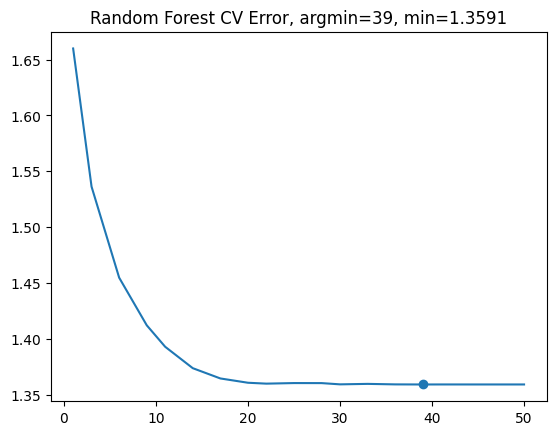

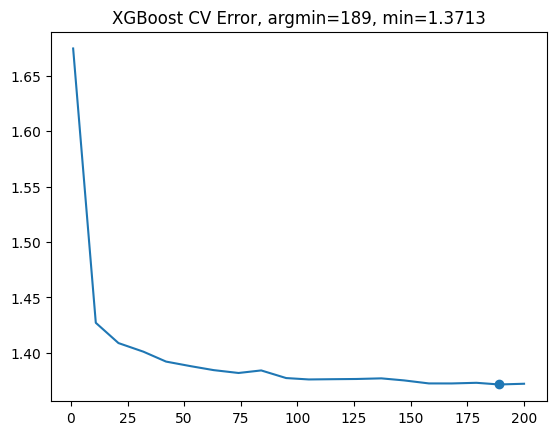

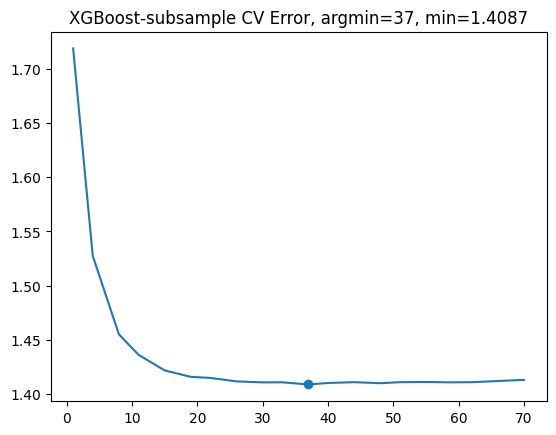

In [4]:
## Import Tuned Parameters
query = "select * from cv_error where seed=%i"%seed
cve_read = pd.read_sql(query,con)

Model_names = np.unique(cve_read.Model)
model_n = Model_names.shape[0]
tuned_params = {}
for i,m in enumerate(Model_names):
    temp = cve_read.loc[cve_read.Model==m]
    idx = temp.Tune_Param=='CV_grid'
    grid = temp[idx].values[0][3:]
    val = temp[~idx].values[0][3:]
    if np.isin('None', grid):
        grid = [None if x=='None' else x for x in grid]
    plt.plot(grid,val)
    plt.scatter(grid[val.argmin()],val[val.argmin()])
    plt.title('%s CV Error, argmin=%i, min=%0.4f'%(m,grid[val.argmin()],val[val.argmin()]))
    plt.show()
    tuned_params[m] = grid[val.argmin()]

In [5]:
ATE_all = pd.read_sql("SELECT * from ATE where Method = 'Nonparametric'", con)
ATE_all_pivot = ATE_all.pivot(index=['Model','Seed','Param_val'], columns='Treatment', values='Treat_Val')
ATE_all_pivot_T = ATE_all_pivot.T
ATE_all_pivot_T = ATE_all_pivot_T.reindex(ATE_names)
ATE_all_pivot_T.index = plot_names
with pd.option_context('display.precision', 4):
    display(ATE_all_pivot_T)

Model                                                   RF             XGB  \
Seed                                                    42      43      42   
Param_val                                               39      30     189   
Baby - No Baby                                      0.0519  0.0492  0.0973   
Teenager - No Teenager                              0.0172  0.0161 -0.0058   
Grandparents - No Grandparents                     -0.0482 -0.0464 -0.0553   
Homeowner - Lease                                   0.1548  0.1521  0.1775   
Female - Male                                       0.0250  0.0264  0.0603   
Head - Not Head                                     0.0115  0.0133  0.0224   
Live Together - Separate                           -0.0133 -0.0086 -0.0333   
College Education - No College Education            0.0567  0.0535  0.1768   
Work - No Work                                      0.0176  0.0167  0.0826   
Receive Social Insurance - Has Never Received       0.0590  0.0602  0.1210   
Had Received Social Insurance - Has Never Received  0.0089  0.0042  0.0059   
Religion - No Religion                              0.1282  0.1273  0.1997   
Married - Not Married                               0.2786  0.2751  0.3164   
Very Healty (5) - Very Unhealty (1)                 1.1866  1.1788  0.9555   
Exercise regularly (3) - No Exercise (0)            0.2773  0.2717  0.2904   
Smoke - No Smoke                                   -0.1518 -0.1552 -0.2218   
Alcohol - No Alcohol                               -0.0081 -0.0091  0.0059   

Model                                                         XGBs          
Seed                                                    43      42      43  
Param_val                                              189      37      37  
Baby - No Baby                                      0.0973  0.1112  0.1180  
Teenager - No Teenager                             -0.0058  0.0426  0.0532  
Grandparents - No Grandparents                     -0.0553 -0.0876 -0.1031  
Homeowner - Lease                                   0.1775  0.1801  0.1754  
Female - Male                                       0.0603  0.0752  0.0663  
Head - Not Head                                     0.0224  0.0673  0.0540  
Live Together - Separate                           -0.0333 -0.0870 -0.0373  
College Education - No College Education            0.1768  0.1334  0.1320  
Work - No Work                                      0.0826  0.0630  0.0592  
Receive Social Insurance - Has Never Received       0.1210  0.1091  0.1058  
Had Received Social Insurance - Has Never Received  0.0059  0.0450  0.0600  
Religion - No Religion                              0.1997  0.1961  0.2141  
Married - Not Married                               0.3164  0.3320  0.3114  
Very Healty (5) - Very Unhealty (1)                 0.9555  1.1044  1.0333  
Exercise regularly (3) - No Exercise (0)            0.2904  0.3446  0.3006  
Smoke - No Smoke                                   -0.2218 -0.1950 -0.2021  
Alcohol - No Alcohol                                0.0059  0.0032 -0.0134

Notice that the results in XGB does not change across seed. This is because XGB without any row subsampling is a deterministic procedure. In each of the boosting rounds, a decision tree is fitted on the residuals. Since the tree growing algorithm is deterministic, there is no randomness (given data). On the other hand, bootstrap (RF) or row subsampling (XGBs) introduces randomness to the model. However, the randomness here may be made smaller if we bootstrap or subsample enough number of times, at the cost of computational burden.

#### ATE with Contingent Variable
Define $X=(V,W)$ and let
$$
Y = f(D,V,W) + \varepsilon
$$
where $\mathbb{E}(\varepsilon|D,X)=0$. We obtain the ATE with contingent variable $V$ from
$$
\mathbb{E}(f(D,V,W)|D=1,V=v) = \mathbb{E}(f(1,V,W)|V=v) \approx \frac{\sum_{i=1}^n\hat{f}(1,v_i,w_i)K(\frac{v-v_i}{h})}{\sum_{i=1}^nK(\frac{v-v_i}{h})}
$$
where $\hat{f}$ is estimated by RF, XGB, or XGB with row subsampling. $V$ is given by either log household income or individual age. Here, Gaussian kernel density function with bandwidth parameter 1 has been used. Ideally, the bandwidth parameter should be chosen more carefully.

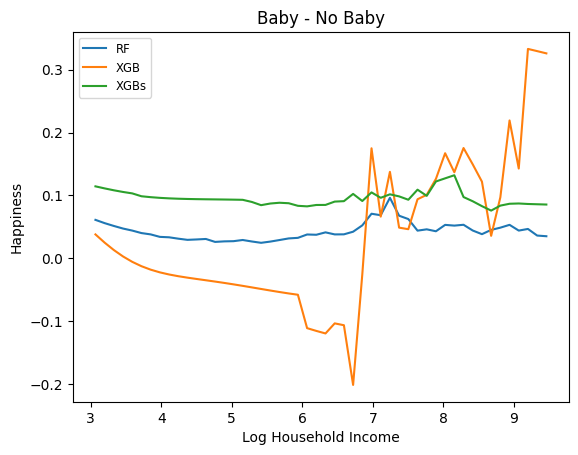

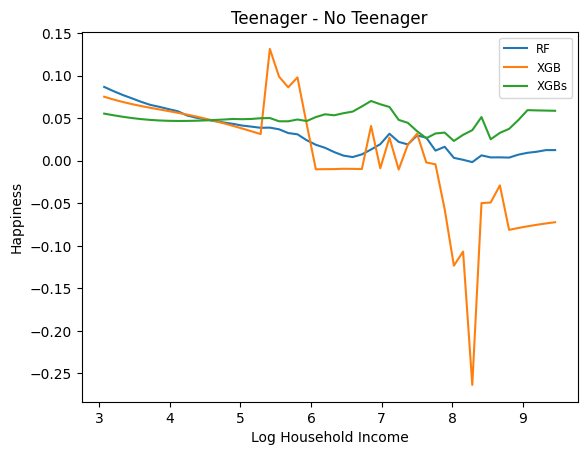

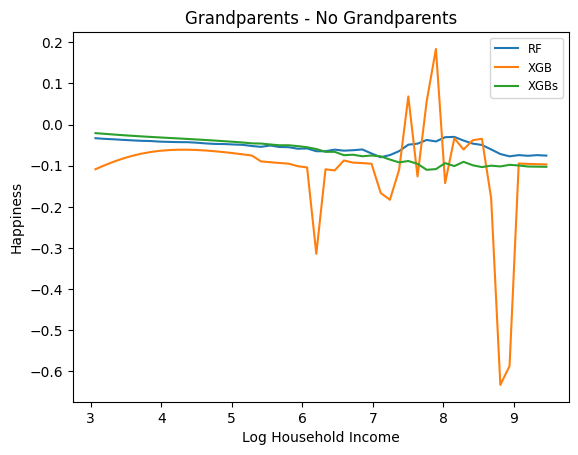

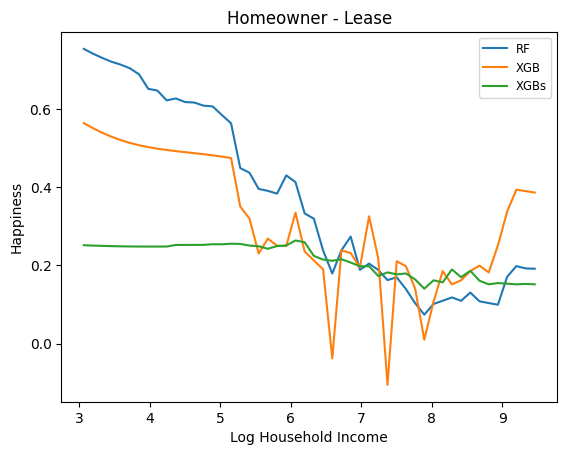

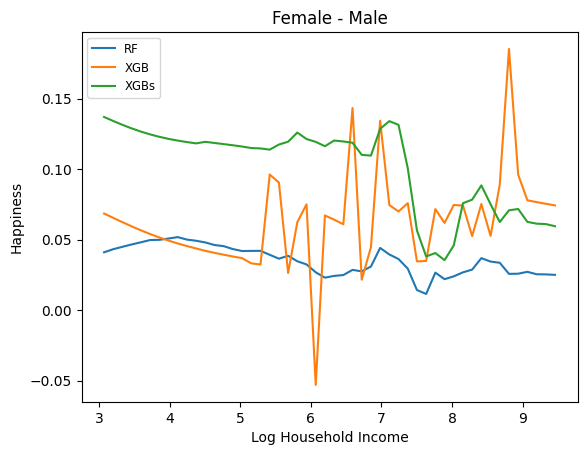

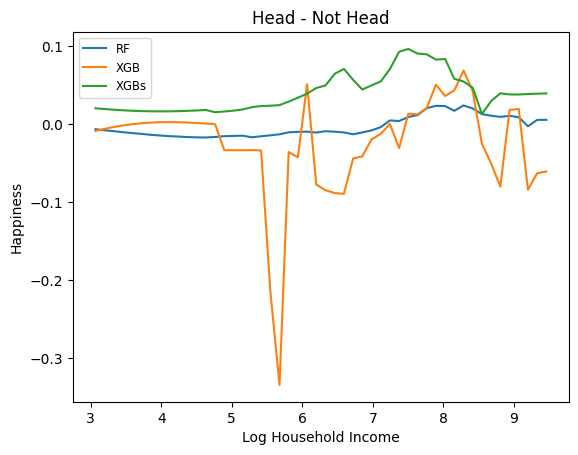

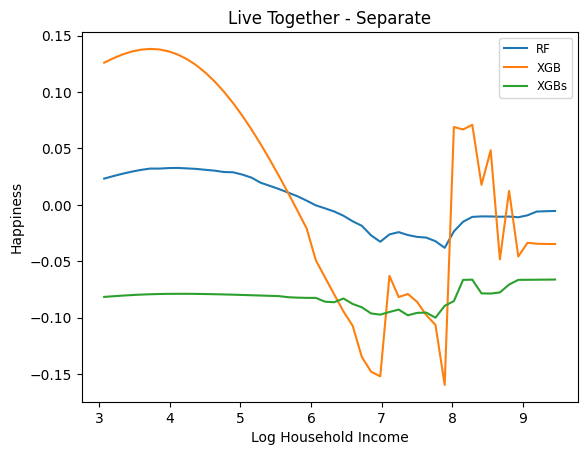

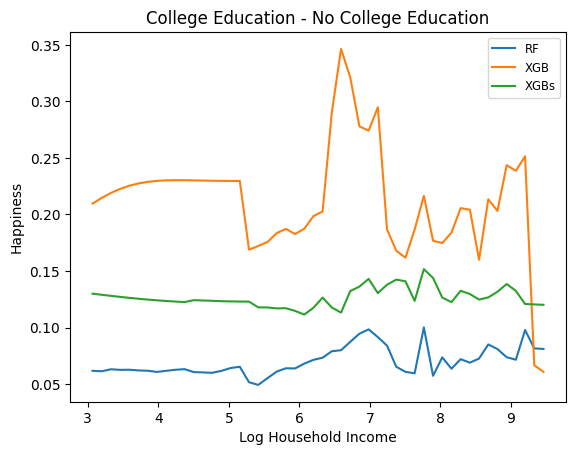

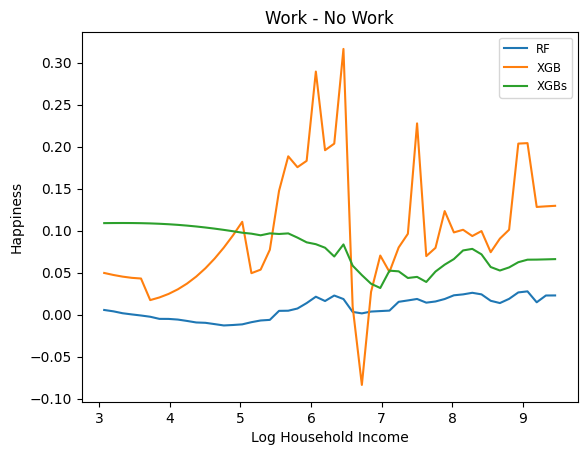

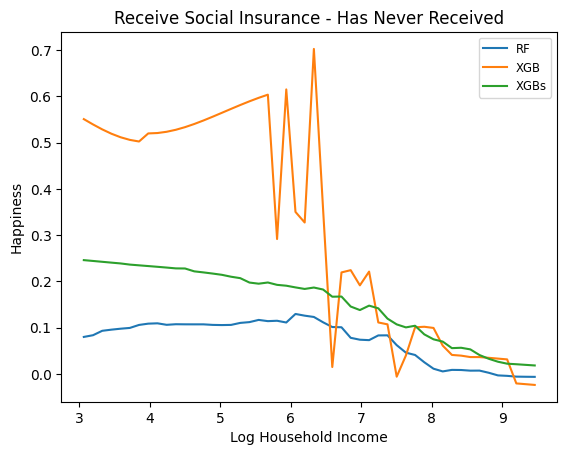

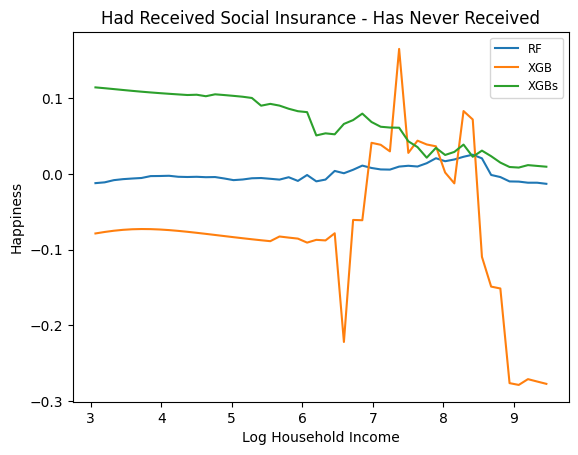

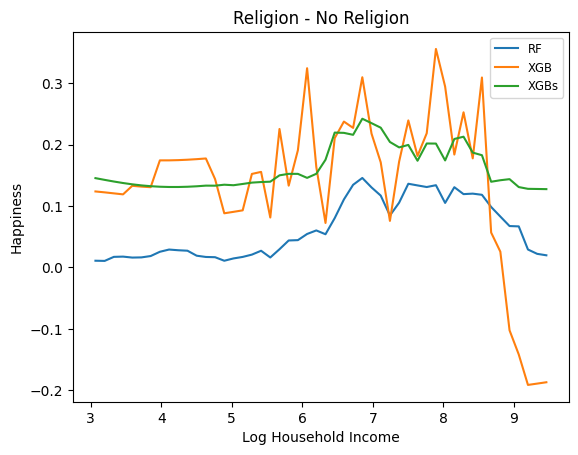

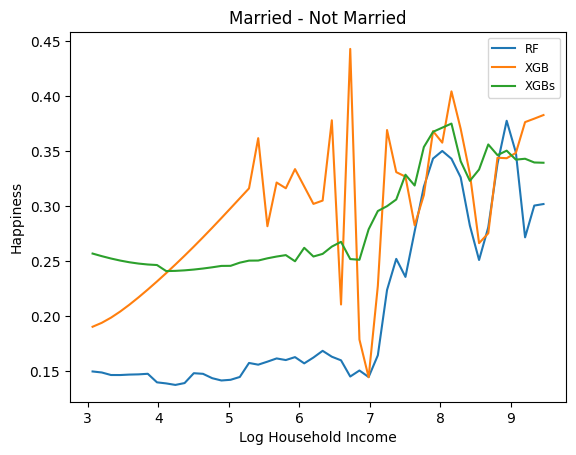

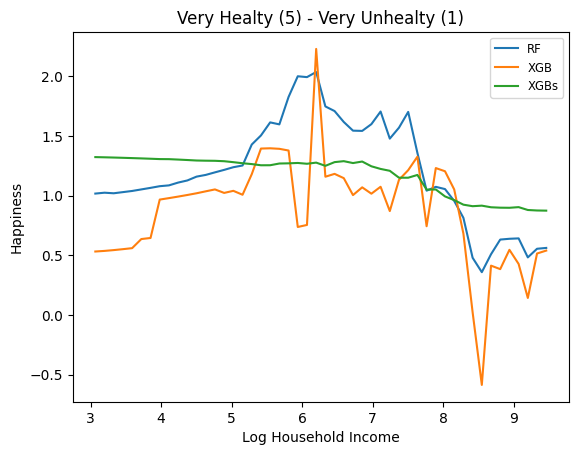

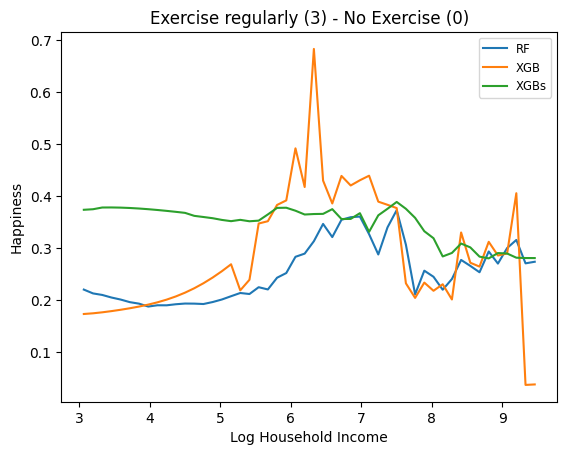

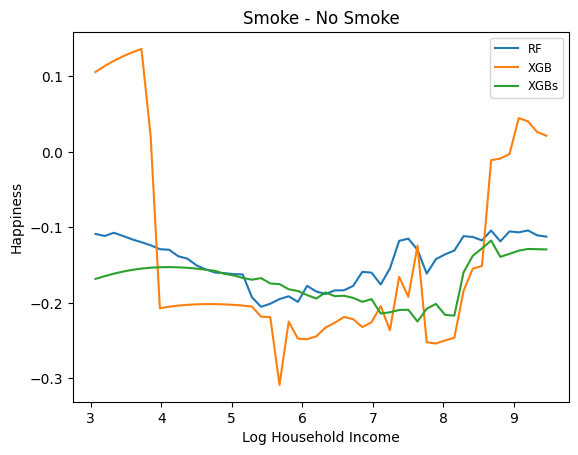

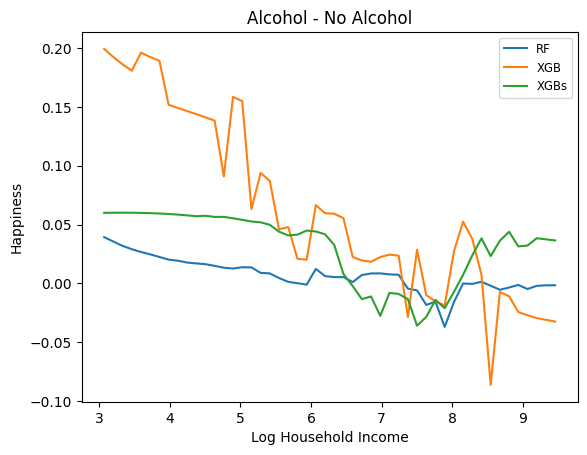

In [6]:
CATE_all_w = pd.read_sql("SELECT * from CATE where Method = 'Nonparametric' and Conditional='hh_inc'", con)
CATE_all_w_pd_pivot = CATE_all_w.pivot(index = ['Model','Seed','Treatment','Param_val'],columns=['Condi_Val'],values='Treat_Val')
for i,tm in enumerate(plot_names):
    tm = ATE_names[i]
    data = CATE_all_w_pd_pivot.query("Treatment=='%s' and Seed == 42"% tm)
    plt.plot(w_grid, data.T.values)
    plt.legend([val[0] for val in data.index],fontsize='small')
    plt.title(plot_names[i])
    plt.xlabel('Log Household Income')
    plt.ylabel('Happiness')
    # #     # plt.savefig('Figures/CATE_all_%s_w.png'%tm)
    # #     # plt.close()
    plt.show()

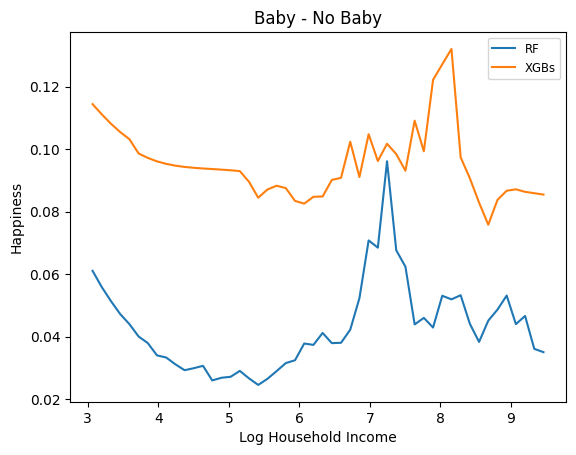

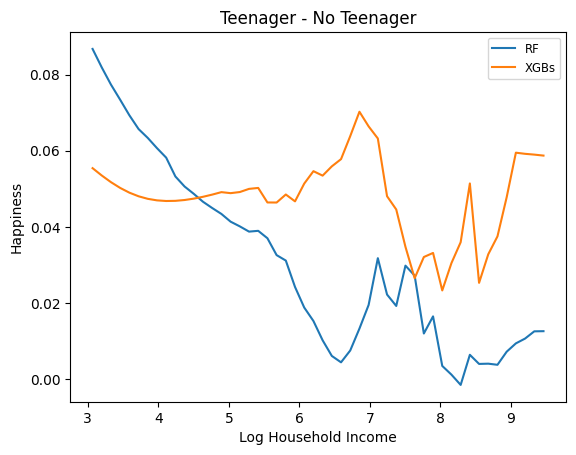

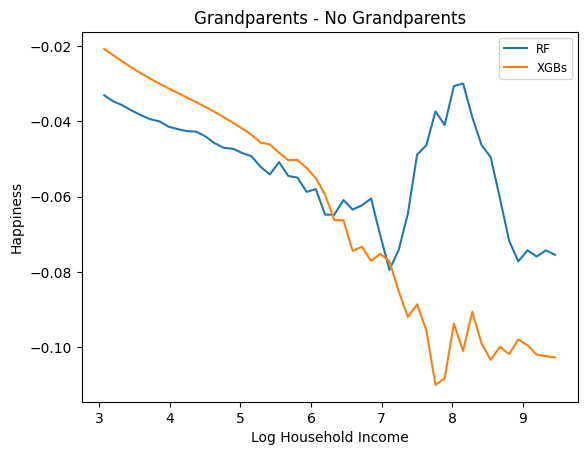

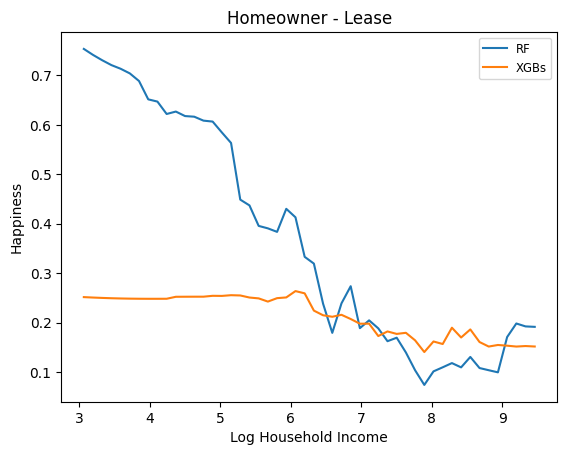

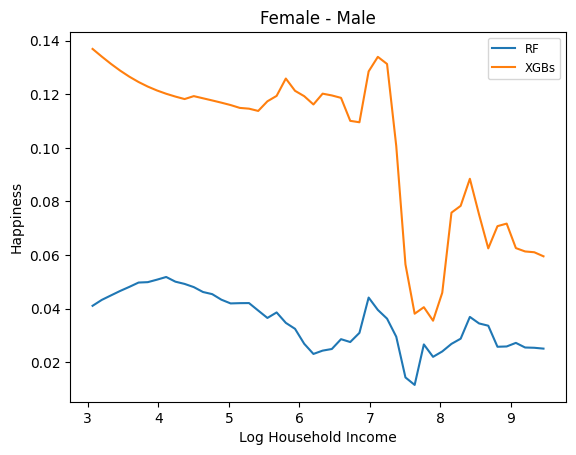

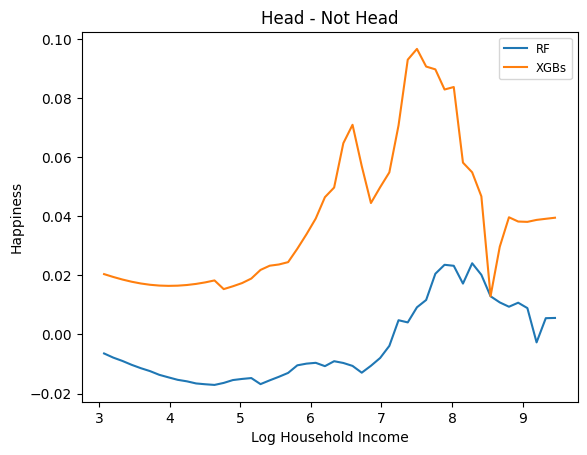

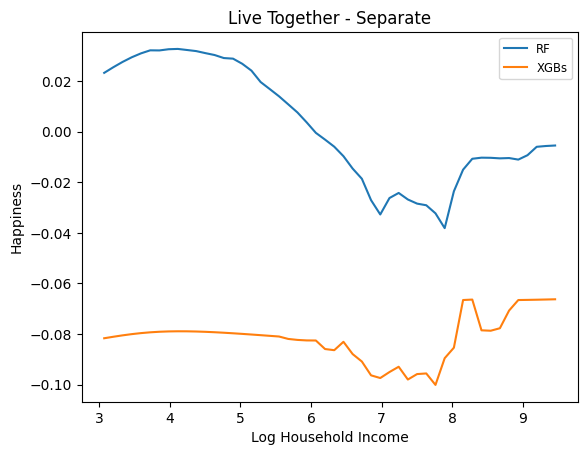

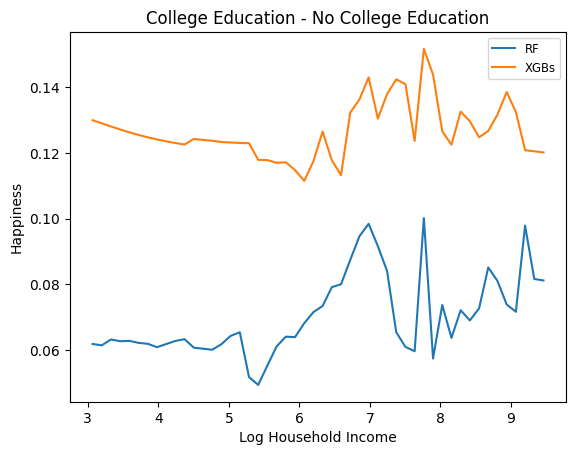

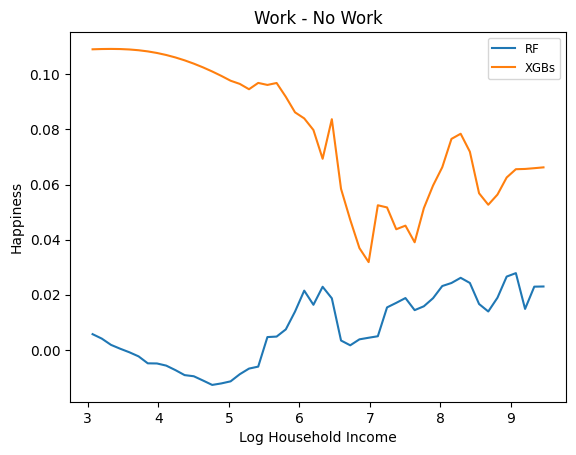

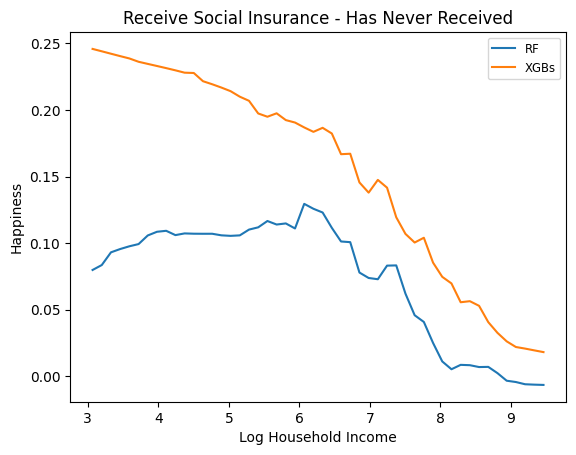

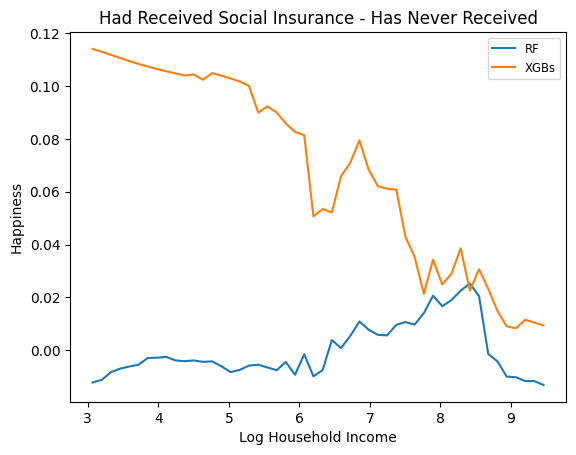

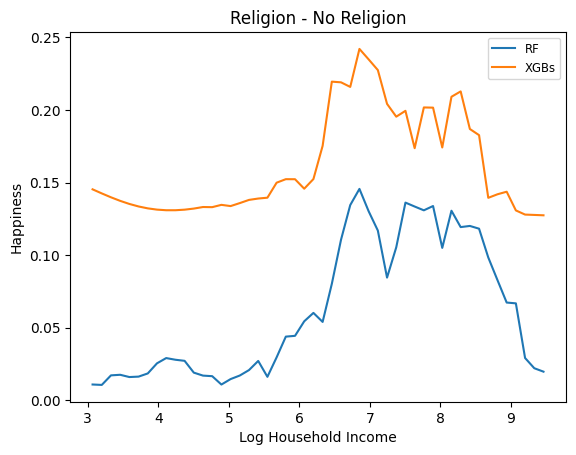

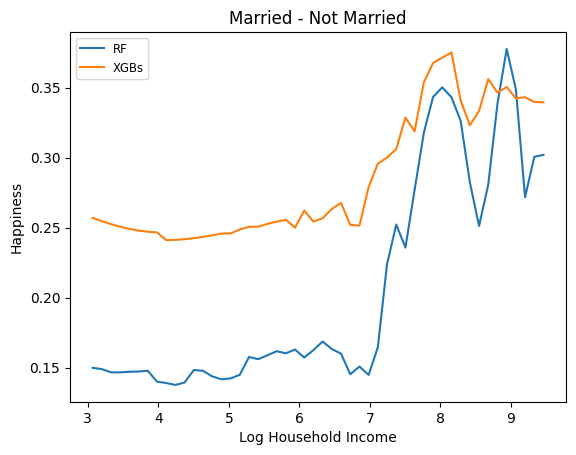

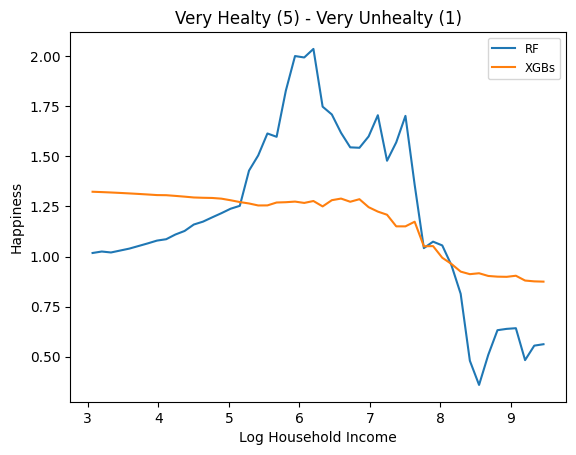

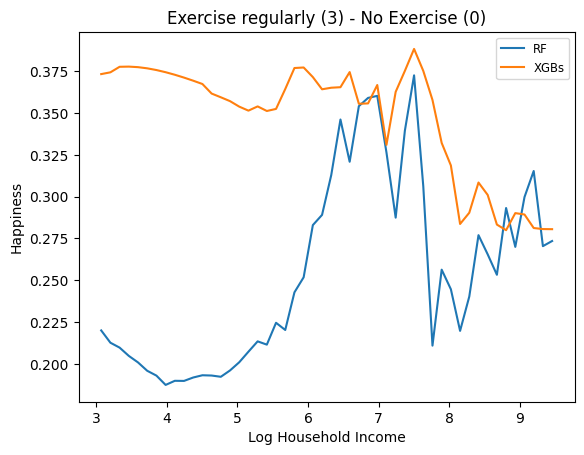

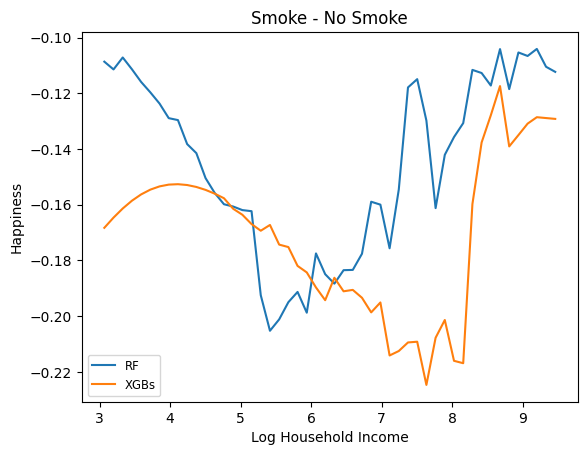

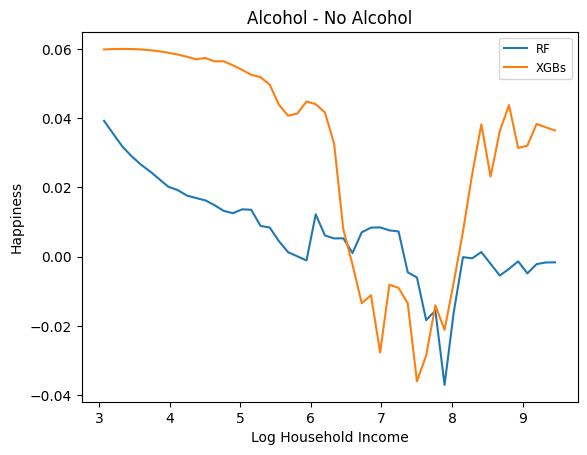

In [7]:
CATE_all_w = pd.read_sql("SELECT * from CATE where Method = 'Nonparametric' and Conditional='hh_inc'", con)
CATE_all_w
CATE_all_w_pd_pivot = CATE_all_w.pivot(index = ['Model','Seed','Treatment','Param_val'],columns=['Condi_Val'],values='Treat_Val')
# CATE_all_w_pd_pivot

for i,tm in enumerate(plot_names):
    tm = ATE_names[i]
    data = CATE_all_w_pd_pivot.query("Treatment=='%s' and Model!='XGB' and Seed == 42"% tm)
    plt.plot(w_grid, data.T.values)
    plt.legend([val[0] for val in data.index],fontsize='small')
    plt.title(plot_names[i])
    plt.xlabel('Log Household Income')
    plt.ylabel('Happiness')
    # #     # plt.savefig('Figures/CATE_all_%s_w.png'%tm)
    # #     # plt.close()
    plt.show()

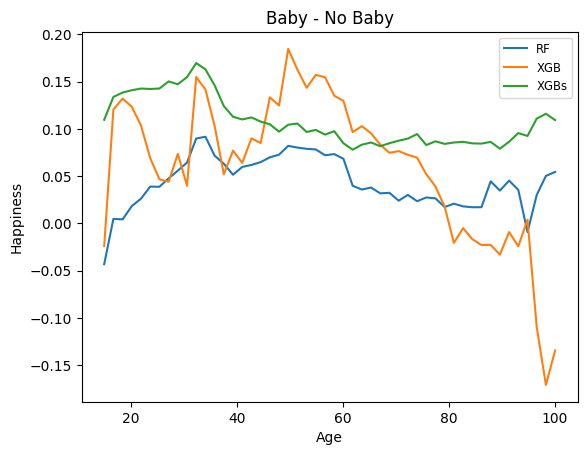

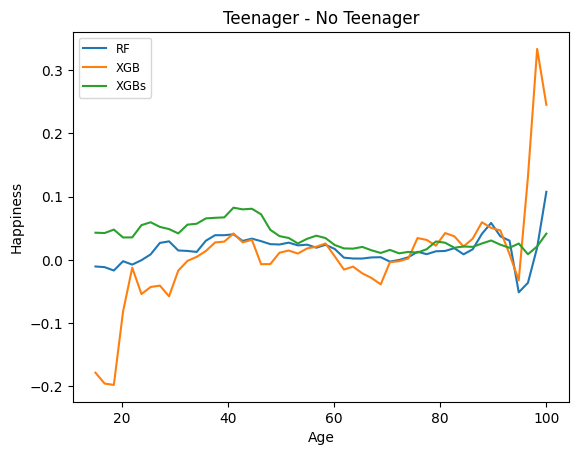

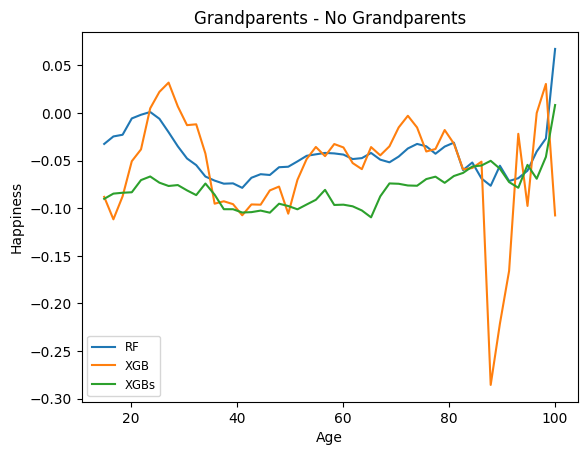

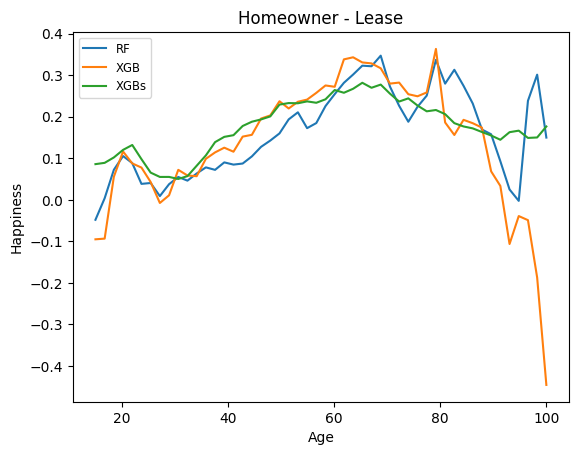

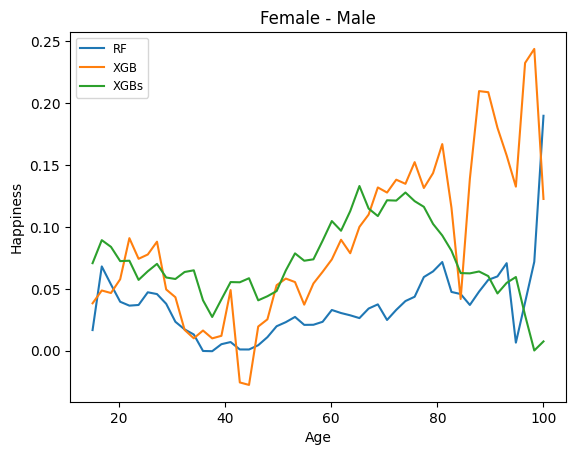

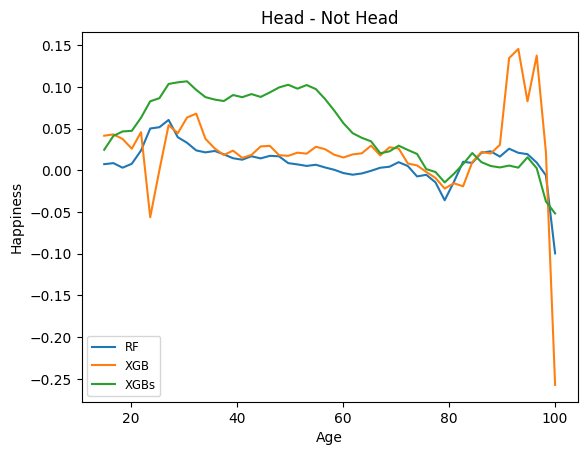

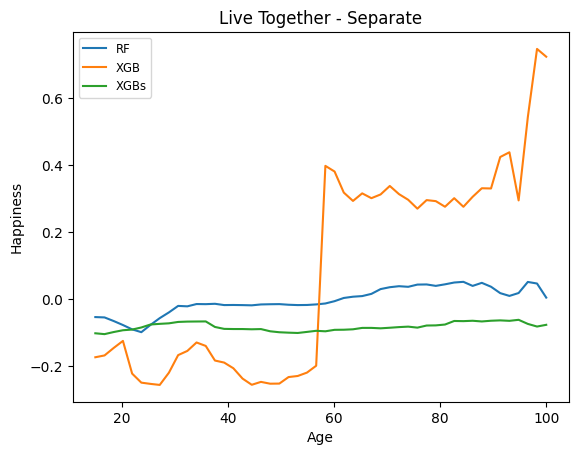

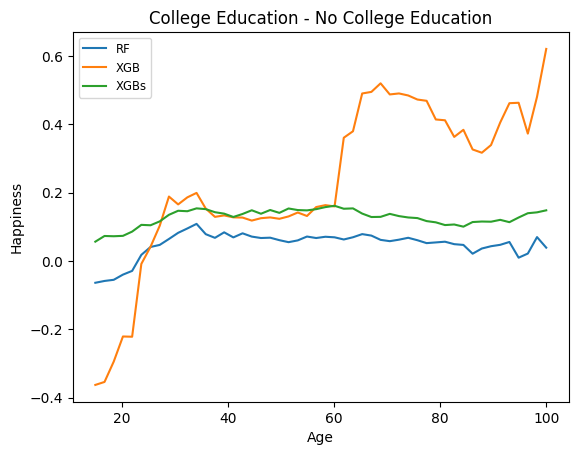

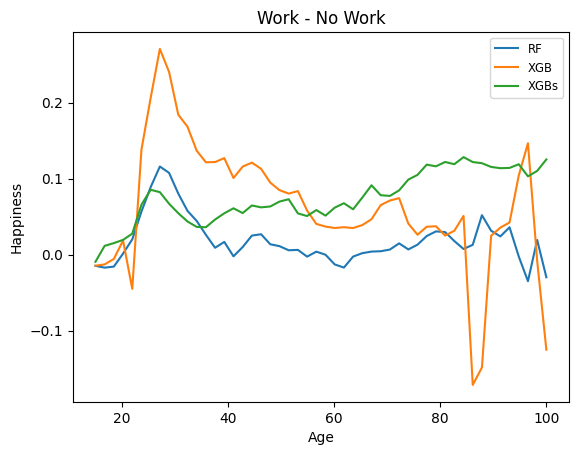

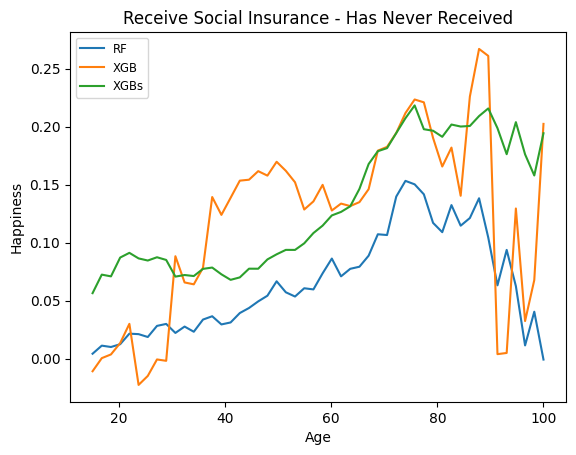

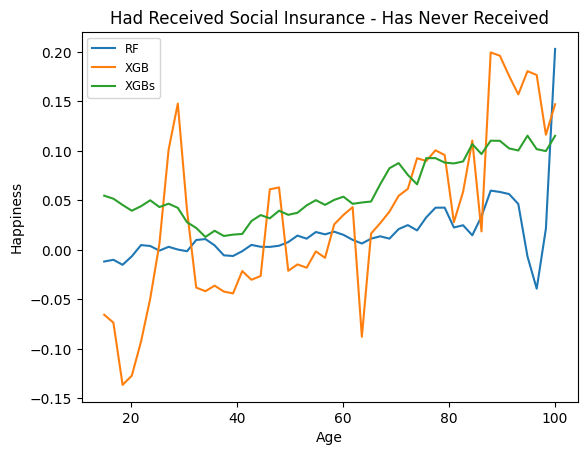

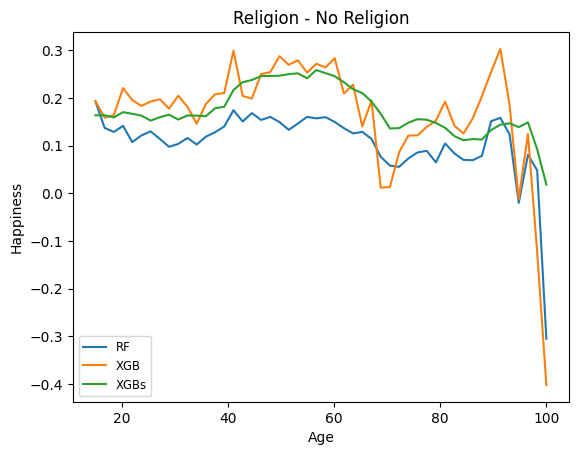

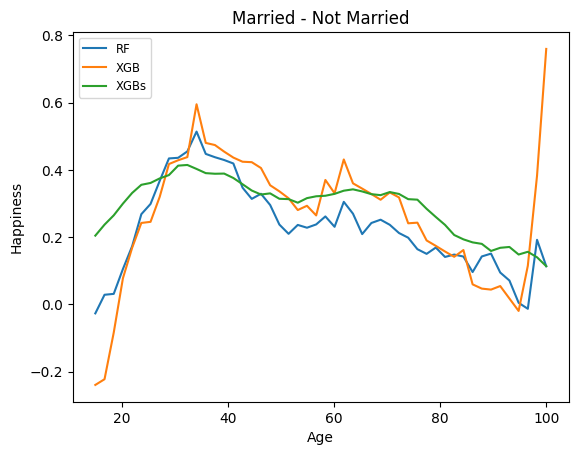

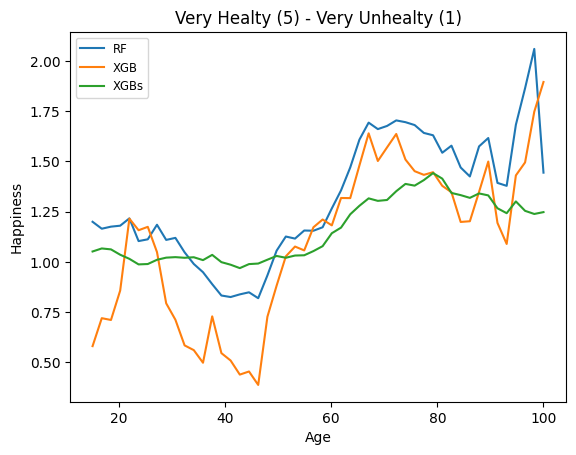

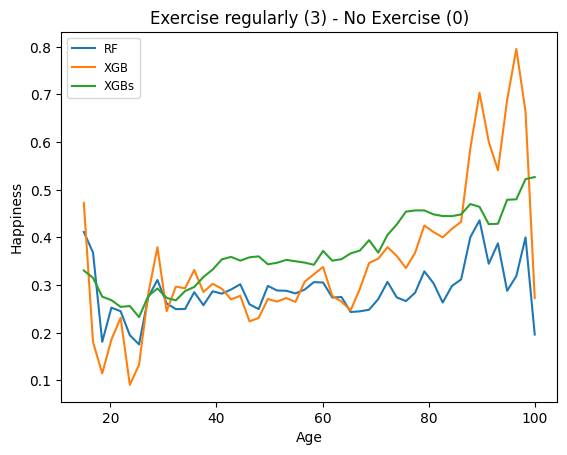

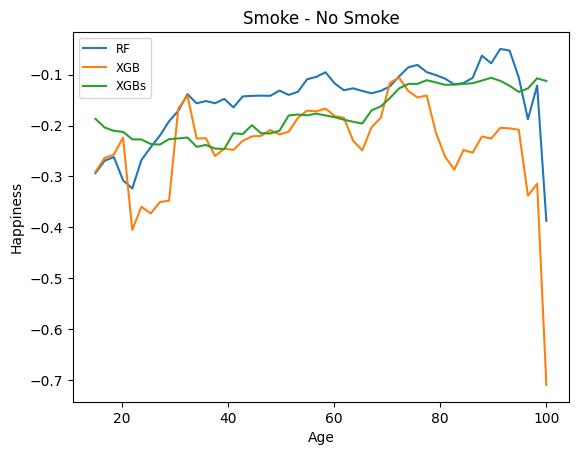

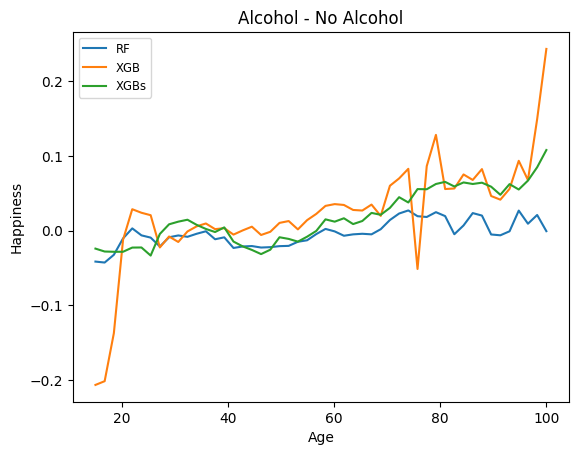

In [8]:
CATE_all_a = pd.read_sql("SELECT * from CATE where Method = 'Nonparametric' and Conditional='age'", con)
# CATE_all_a
CATE_all_a_pd_pivot = CATE_all_a.pivot(index = ['Model','Seed','Treatment','Param_val'],columns=['Condi_Val'],values='Treat_Val')

for i,tm in enumerate(plot_names):
    tm = ATE_names[i]
    data = CATE_all_a_pd_pivot.query("Treatment=='%s' and Seed==42"% tm)
    plt.plot(a_grid, data.T.values)
    plt.legend([val[0] for val in data.index],fontsize='small')
    plt.title(plot_names[i])
    plt.xlabel('Age')
    plt.ylabel('Happiness')
    # plt.savefig('Figures/CATE_all_%s_a.png'%tm)
    # plt.close()
    plt.show()

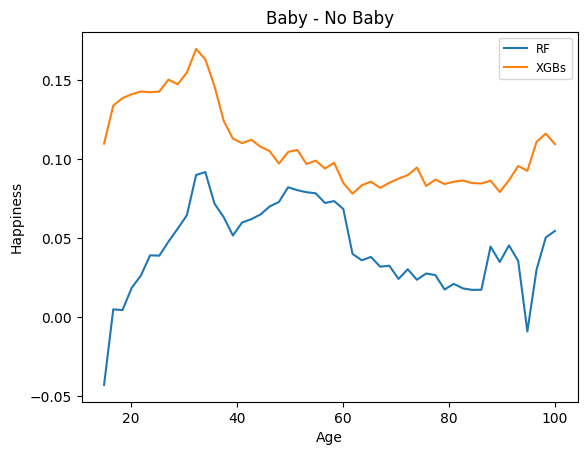

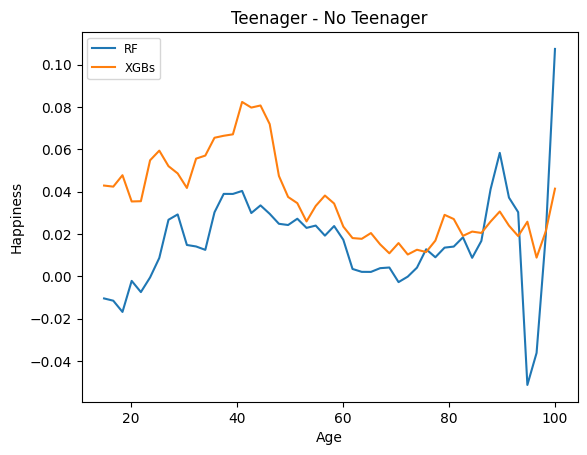

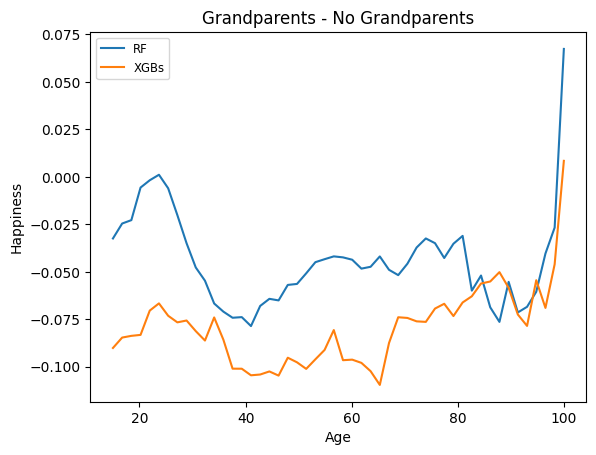

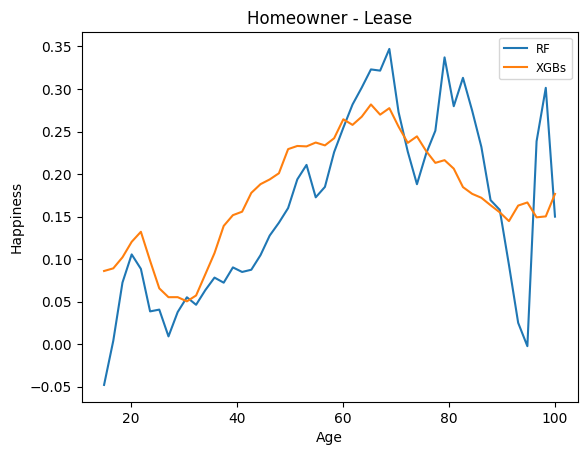

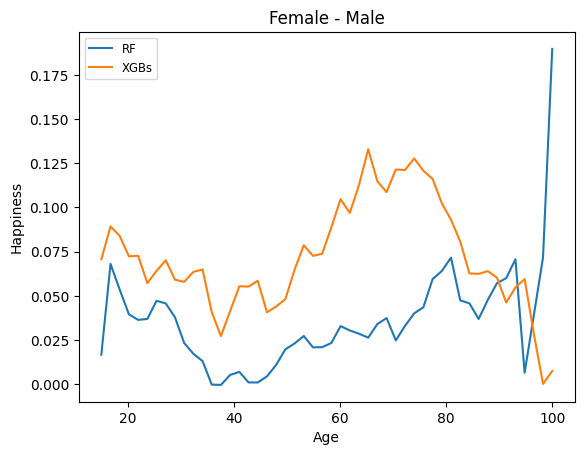

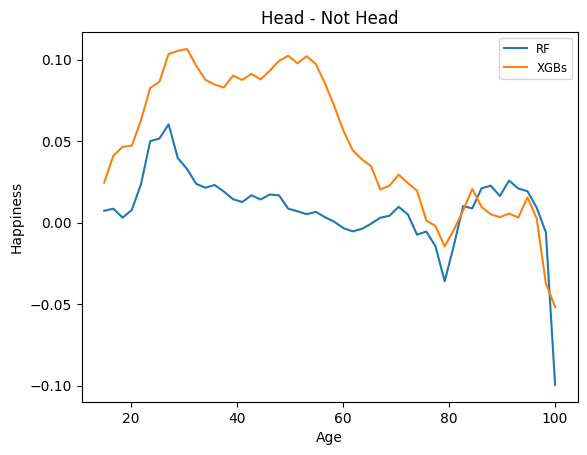

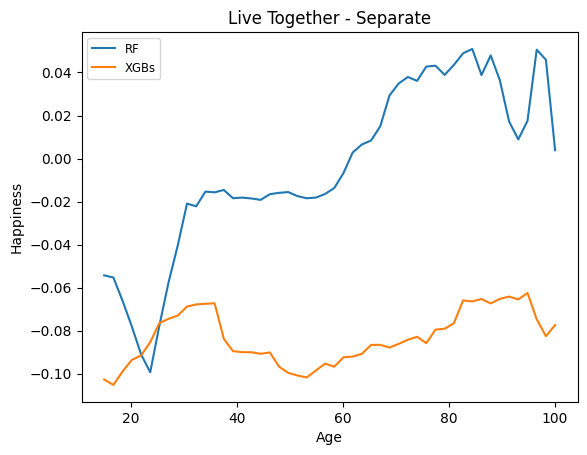

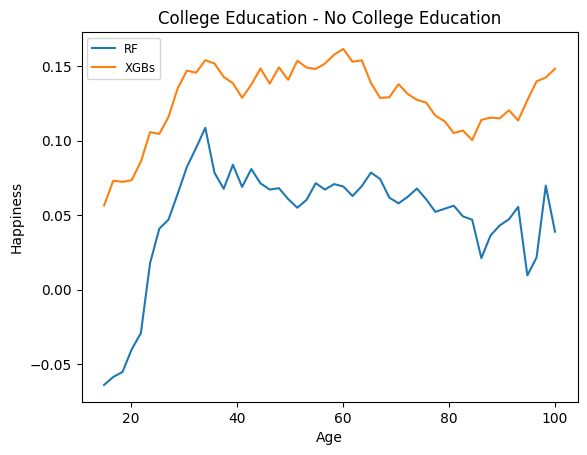

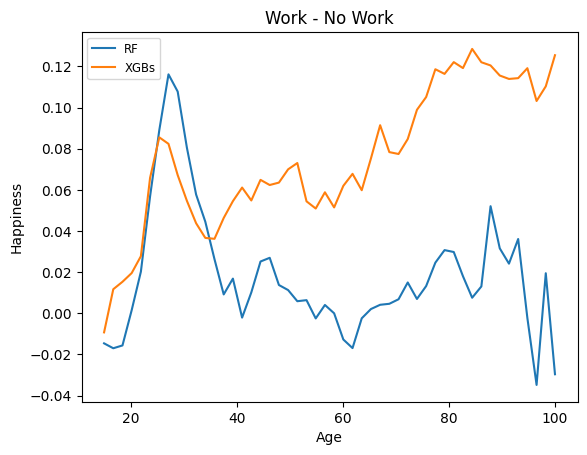

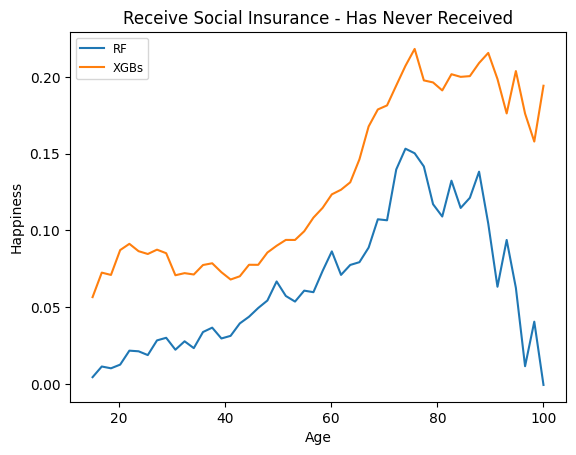

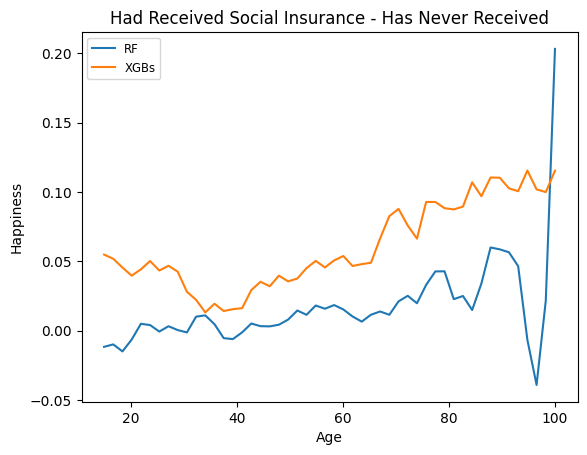

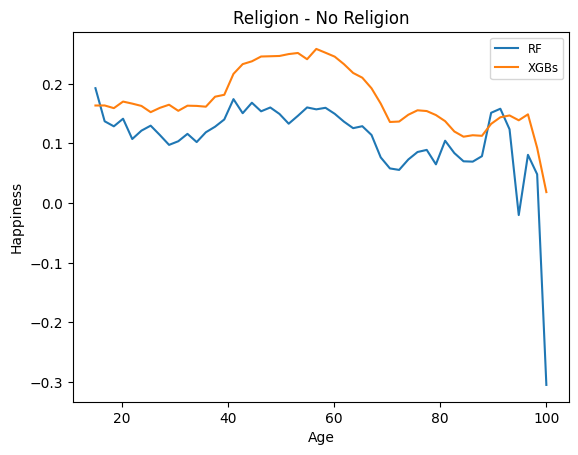

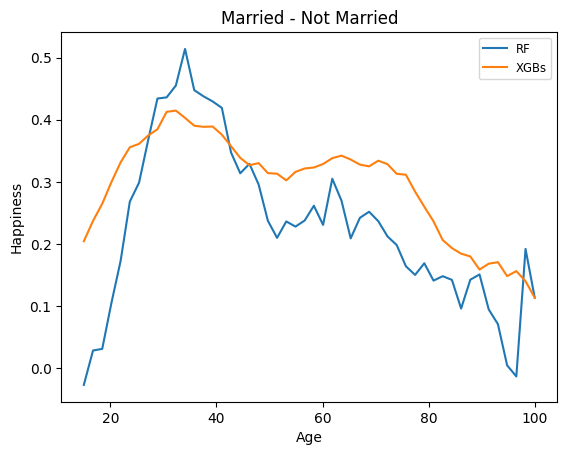

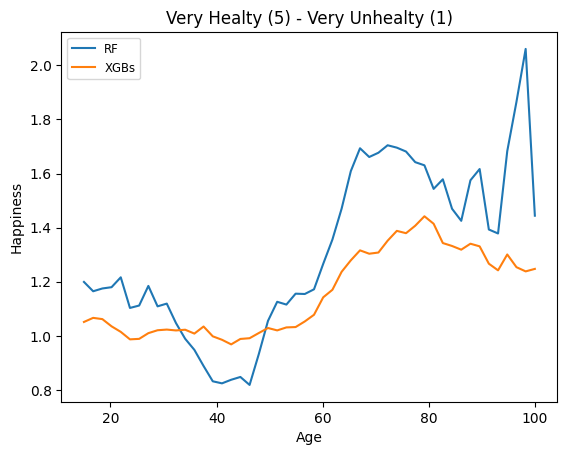

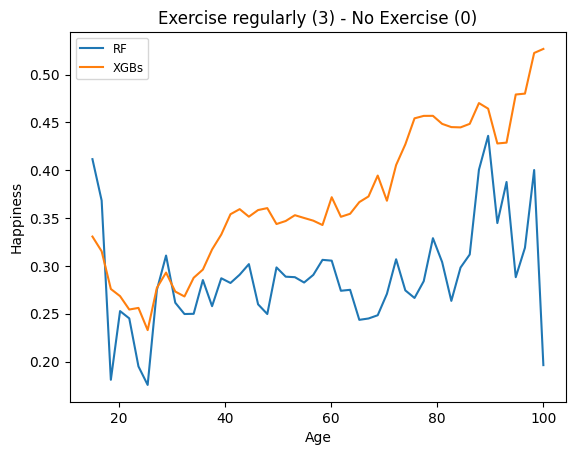

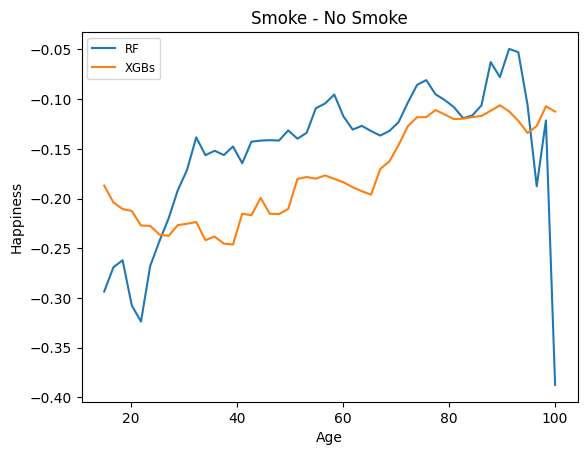

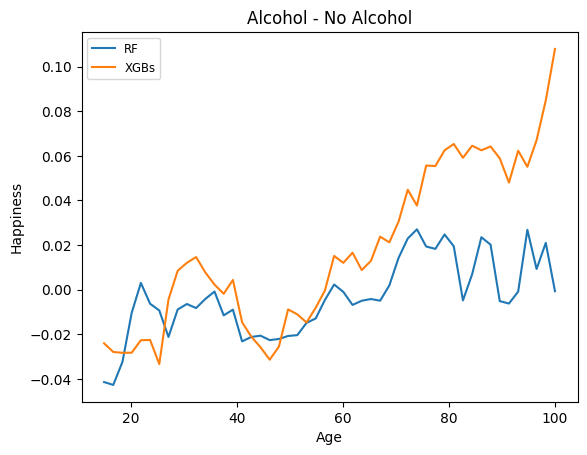

In [9]:
CATE_all_a = pd.read_sql("SELECT * from CATE where Method = 'Nonparametric' and Conditional='age'", con)
# CATE_all_a
CATE_all_a_pd_pivot = CATE_all_a.pivot(index = ['Model','Seed','Treatment','Param_val'],columns=['Condi_Val'],values='Treat_Val')

for i,tm in enumerate(plot_names):
    tm = ATE_names[i]
    data = CATE_all_a_pd_pivot.query("Treatment=='%s' and Model!='XGB' and Seed==42"% tm)
    plt.plot(a_grid, data.T.values)
    plt.legend([val[0] for val in data.index],fontsize='small')
    plt.title(plot_names[i])
    plt.xlabel('Age')
    plt.ylabel('Happiness')
    # plt.savefig('Figures/CATE_all_%s_a.png'%tm)
    # plt.close()
    plt.show()